# <div style="text-align: center">18.335/6.337 Problem Set 1 - SVD and Norms</div>
## <div style="text-align: center">Solutions</div>

### <div style="text-align: right">Creaed by Wonseok Shin</div>

## Problem 1.  Visualization of SVD [3 pts]
A matrix $A$ transforms the unit sphere into a hyper-ellipsoid, whose shape is specified by SVD: $A=U \Sigma V^*$.  Specifically, 
- the columns of $U$ (left singular vectors) correspond to the directions of the semi-principal axes of the hyper-ellipsoid, and
- the diagonal entries of $\Sigma$ (singular values) correspond to the lengths of the semi-principal axes of the hyper-ellipsoid.

Therefore, to draw the hyper-ellipsoid is a nice way to visualize SVD.

The goal of this problem is to verify, for a simple 2D case, if the hyper-ellipsoid specified by $U$ and $\Sigma$ is indeed the image of the unit sphere under $A$.

### Assignment 1.1 [1 pt]
Suppose that $A\in \mathbb{R}^{2\times2}$ is given, and its SVD is $A=U \Sigma V^\top$.  (Note that $V^\top$ is used instead of $V^*$; when $A$ is real, $U$ and $V$ can be chosen real.)  Your first task is to find the equation of the ellipse into which the unit circle is transformed by $A$.

The equation of an ellipse whose principal axes are aligned with the $x$- and $y$-axes is $\frac{x^2}{a^2}+\frac{y^2}{b^2}=1$, but the ellipse we want to describe is a rotated version of it.  What would be the equation of this rotated ellipse in terms of $U$ and $\Sigma$?

Once you find out the equation, write it down in the form of $f(x,y)=0$ (e.g., if your equation is $\frac{x^2}{a^2}+\frac{y^2}{b^2}=1$, then $f(x,y) = \frac{x^2}{a^2}+\frac{y^2}{b^2}-1 = 0$).  Implement `fun_ellipse()` below to return this $f$.  (Later, we will use $f(x,y)$ to draw the ellipse as a coutour plot with level = 0.)

To obtain $U$ and $\Sigma$ from a given $A$, you will need to perform SVD inside `fun_ellipse()`.  This can be done by using Julia's `svd()` function.  Read the [documentation](http://docs.julialang.org/en/release-0.5/stdlib/linalg/#Base.svd) of `svd()` to learn the usage.

*Solution*.

In [1]:
function fun_ellipse(A)
    U, σ, ~ = svd(A)

    return (x,y) -> norm((U'*[x,y]) ./ σ) - 1.  # (x,y) -> f(x,y) is an anonymous function
end

fun_ellipse (generic function with 1 method)

### Assignment 1.2 [1 pt]
Next, complete `vert_ellipse()` below to return the coordinates of the vertex and co-vertex of the ellipse.  The vertex and co-vertex of an ellipse are the end points of the major and minor axes, respectively, as indicated in the figure below (taken from http://www.mathwarehouse.com):

<img src="ellipse.gif">

There are two vertices and co-vertices, but you need to return the coordinates of only one vertex and one co-vertex.  The coordinates of the vertex and co-vertex can be deduced from $U$ and $\Sigma$, so you will need to use Julia's `svd()` function again inside `vert_ellipse()`.

*Solution*.

In [2]:
function vert_ellipse(A)
    U, σ, ~ = svd(A)

    vertex = σ[1] .* U[:,1]
    covertex = σ[2] .* U[:,2]

    return vertex, covertex
end

vert_ellipse (generic function with 1 method)

### Assignment 1.3 [1 pt]
So far, we have deduced the shape of the ellipse into which the unit circle is transformed by $A$.  To verify the deduction, we want to check if the actual points on the unit circle are mapped by $A$ to our deduced ellipse.

Complete `calc_AS¹` below that uniformly samples about 50 points on the unit circle and transforms them by $A$.  (Here, $S^1$ means the [1-sphere](https://en.wikipedia.org/wiki/N-sphere).) 

*Solution*.

Below, I will introduce two different versions of `calc_AS¹()`.  This is just to illustrate that you can achieve extra speedup by paying attention to the *number of array allocations*.  (Points will not be deducted from your score for not paying attention to this aspect.)  Allocating memory for arrays is usually very costly, so you have to be really serious about reducing the number of array allocations in performance-critical code.

In the faster version of `calc_AS¹()`, we will use a `for` loop.  Using `for` loops is usually not recommended in MATLAB and Python, because `for` loops are slow in those [interpreted languages](https://en.wikipedia.org/wiki/Interpreted_language).  Julia, on the other hand, is a [compiled language](https://en.wikipedia.org/wiki/Compiled_language), which generates optimized machine code for the `for` loops.  Therefore, using `for` loops in Julia is not discouraged at all, and often encouraged when better performance can be achieved by doing so.

Here is the first version of `calc_AS¹()`:

In [3]:
function calc_AS¹(A)  # version 1
    θ = linspace(0, 2π, 51)[1:end-1]  # eliminate last entry because θ = 0 and θ = 2π are same point
    X = [cos(θ) sin(θ)]'
    Z = A*X

    return Z  # 2-by-n array with n ≈ 50
end

calc_AS¹ (generic function with 1 method)

and this is the time taken to run it with a random $2\times 2$ matrix:

In [4]:
A = rand(2,2);
calc_AS¹(A); @elapsed calc_AS¹(A)

2.4009e-5

(The reason we call `calc_AS¹(A)` before `@elapsed` is to initiate compilation of the function.  Julia compiles a function when it is called for the first time, so the first call of a function usually takes significantly longer than subsequent calls.)

Though the first version of `calc_AS¹()` is very compact, it does not pay enough attention to the number of array allocations.  Specifically, it allocates a large array to store the matrix `X`, which can be avoided in the following second version of `calc_AS¹()`:

In [5]:
function calc_AS¹(A)  # version 2
    n = 50
    ∆θ = 2π/n
    Z = Array{Float64}(2,n)
    for k = 1:n
        θ = k * ∆θ
        c = cos(θ)
        s = sin(θ)
        Z[1,k] = A[1,1]*c + A[1,2]*s
        Z[2,k] = A[2,1]*c + A[2,2]*s
    end

    return Z  # 2-by-n array with n ≈ 50
end

calc_AS¹ (generic function with 1 method)

In this second version of `calc_AS¹()`, the two entries of each column of `X` are stored in the local variables `c` and `s`.  Unlike arrays that are stored in the *heap*, these local variables are stored in the *stack* and can be managed much more efficiently.  (See a brief comparison between the heap and stack [here](http://stackoverflow.com/questions/79923/what-and-where-are-the-stack-and-heap).)  As a result, the second version of `calc_AS¹()` runs faster than the first version:

In [6]:
calc_AS¹(A); @elapsed calc_AS¹(A)

4.18e-6

Reducing the number of heap allocations is not something that is always recommended.  For example, code with reduced number of heap allocations may take longer to compile.  Also, you cannot always fit all the variables in the stack.  (The dreaded "stack overflow" errors occur because of the limited stack size.)  Still, reducing the number of heap allocations is an option to consider in performance-critical situations.

### Verification of your implementation
To verify your implementation of the three functions, run the following code block.  When successful, the code will produce a figure like below.  (The shape of the ellipse can change, because the script randomly generates a test matrix.)

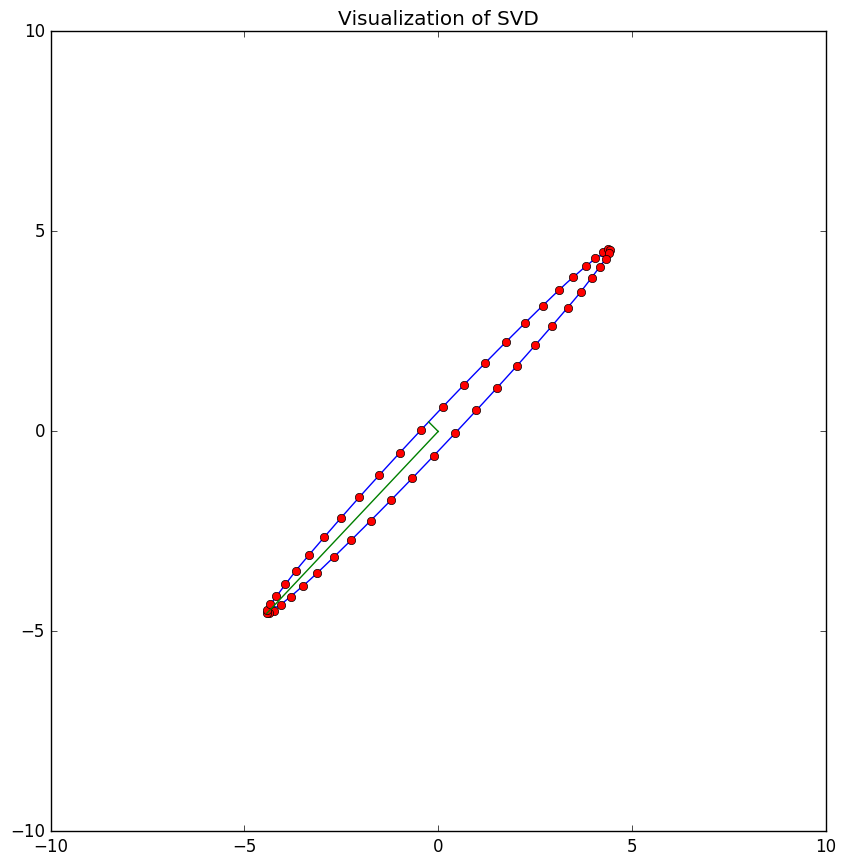

PyObject <matplotlib.text.Text object at 0x324de9358>

In [7]:
# Set up a test matrix.
A = 5*rand(2,2)

# Calculate the ellipse expected to be obtained as a result of transforming the unit circle by A.
fe = fun_ellipse(A)
v, cv = vert_ellipse(A)

# Calculate the actual points transformed by A from the unit circle.
Z = calc_AS¹(A)

# Compare the expectation with the reality.
using PyPlot  # if not installed yet, execute Pkg.add("PyPlot") first

N = 100
x = linspace(-10,10,N)
X = repmat(x',N,1)
y = linspace(-10,10,N)
Y = repmat(y,1,N)

V = fe.(X,Y)

xm = ym = 10
figure(figsize=(xm,ym))

axis([-xm,xm,-ym,ym])
contour(X, Y, V, 0, colors="b")
plot(Z[1,:], Z[2,:], "ro")
plot([0, v[1]], [0, v[2]], "g-")
plot([0, cv[1]], [0, cv[2]], "g-")
title("Visualization of SVD")

## Problem 2.  Low-rank approximation via SVD [4 pts]
In this problem, you will see the efficiency of the low-rank approximation of a matrix via SVD.  Specifically, you will see that the low-rank approximation of our $2000\times2000$ test matrix $A$ allows us to calculate $A x$ much faster with only small error.

### Assignment 2.1 [1 pt]
When the SVD of $A\in \mathbb{C}^{m\times n}$ is $A=\sum _{j=1}^p \sigma _j u_j v_j^*$, the low-rank approximation of $A$ is a partial sum $A=\sum _{j=1}^\nu \sigma _j u_j v_j^*$, where $1\le\nu\le p=\min\{m,n\}$.  

For an accurate-yet-efficient approximation, the correct choice of $\nu$ is very important.  Typically, we only keep the terms with relatively large $\sigma_j$'s.  In this problem set, we will keep all the terms with $\sigma_j$'s greater than or equal to 1% of $\sigma_1$.

Implement `find_ν()` below that takes a vector of $\sigma_j$'s and returns $\nu$ such that $\sigma_\nu / \sigma_1\ge 0.01$ and $\sigma_{\nu +1}/\sigma_1<0.01$.

*Solution*.

In [8]:
function find_ν(σ)  # σ: vector of σⱼ's
    σ₁ = σ[1]
    ν = findlast(σ .≥ 0.01σ₁)

    return ν
end

find_ν (generic function with 1 method)

### Assignment 2.2 [1 pt]
Now, we implement the operation of $A_\nu$ on $x$.  Implement `apply_Aν()` below that takes the SVD components of $A$ together with $\nu$ and $x$, and returns $A_\nu x$.

Hint: when implementing $A B x$ numerically for some matrices $A$ and $B$, it is very important to implement it as $A (B x)$ rather than $(A B) x$.  Why do you think this is the case?  Think about the extreme case where $A$ is a column vector and $B$ is a row vector.  (You don't have to submit the answer to this question.)

*Solution*.

In this solution, we will consider the impact of reducing the number of array allocations again.  (Points will not be deducted from your score for not paying attention to this aspect.)  Here is the first version of `apply_Aν()` that does not pay attention to the number of array allocations:

In [9]:
function apply_Aν(U, σ, V, ν, x)  # version 1
    Uν = U[:,1:ν]
    σν = σ[1:ν]
    Vν = V[:,1:ν]

    yν = Uν * (σν .* (Vν' * x))

    return yν  # yν = Aν x
end

apply_Aν (generic function with 1 method)

In the above version of `apply_Aν()`, copies of the first `ν` columns of the matrices `U` and `V` are created and stored in `Uν` and `Vν`.  These copies are stored in separate memory spaces from the original matrices, which means that these copies consume memory (and therefore need to be allocated).  

You can quickly verify this by observing what happens in the original matrices when you change the contents of the copies: because they are stored in separate memory spaces, changing the contents of the copies does not change the contents of the originals:

In [10]:
A = rand(3,3)

3×3 Array{Float64,2}:
 0.327686  0.384002  0.771   
 0.362511  0.14076   0.287168
 0.543431  0.795323  0.073369

In [11]:
Aν = A[:,1:2];
Aν[1,1] = 0.;
A

3×3 Array{Float64,2}:
 0.327686  0.384002  0.771   
 0.362511  0.14076   0.287168
 0.543431  0.795323  0.073369

Changing the contents of `Aν` did not affect the contents of `A`, so `Aν` and `A` are stored in separate memory spaces.  

In our case, we don't intend to change the contents of `Uν` and `Vν`.  Therefore, making separate copies of the contents of the original `U` and `V` is a waste of memory.  Fortunately, Julia has a macro `@view` that can be used to create a *view* of a portion of an array without creating a copy of that portion:

In [12]:
Aν = @view A[:,1:2];
Aν[1,1] = 0.;
A

3×3 Array{Float64,2}:
 0.0       0.384002  0.771   
 0.362511  0.14076   0.287168
 0.543431  0.795323  0.073369

Now, you see that changing the contents of `Aν` changes the contents of `A`, which means that the view `Aν` is *not* stored separately from the original `A`.  This means that we can avoid unnecessary array allocations by using `@view`.

Let's apply this idea to implementing the second version of `apply_Aν()`.  All you need to do is to put `@view` in front of `U[:,1:ν]`, `σ[1:ν]`, and `V[:,1:ν]`:

In [13]:
function apply_Aν(U, σ, V, ν, x)  # version 2
    Uν = @view U[:,1:ν]
    σν = @view σ[1:ν]
    Vν = @view V[:,1:ν]

    yν = Uν * (σν .* (Vν' * x))

    return yν  # yν = Aν x
end

apply_Aν (generic function with 1 method)

On my computer, the verification code at the end of Problem 2 reported that the first and second versions of `apply_Aν()` are about 20X and 50X faster than direct application of `A`, respectively.

### Assignment 2.3 [1 pt]
To test the accuracy of $A_\nu x$, implement `eval_err()` below that evaluates the average error in $A_\nu x$ for $x$'s taken from the columns of a matrix $X$ passed to the function.  The specific requirements are as follows.
- For each $x$, calculate $A x$ and $A_\nu x$ (using `apply_Aν()`), and also an error $\left\|A_\nu x-A x\right\|_2/\left\| A x\right\|_2$.
- Repeat this error calculation for all $x$ taken from the columns of $X$, and calculate the average error.
- Return the average error.

*Solution*.

In [14]:
function eval_err(A, X, U, σ, V, ν)
    n = size(X, 2)

    err = 0.
    for j = 1:n
        x = @view X[:,j]

        y = A*x
        yν = apply_Aν(U, σ, V, ν, x)
        err += norm(yν - y) / norm(y)
    end

    err /= n

    return err  # average error over columns of X
end

eval_err (generic function with 1 method)

### Assignment 2.4 [1 pt]
To test the performance of $A_\nu x$, implement `eval_time()` below that evaluates the average time taken for calculating $A x$ and $A_\nu x$ for $x$'s taken from the columns of a matrix $X$ passed to the function.  The specific requirements are as follows.
- For each x, time the calculation of $A x$ and $A_\nu x$ (using `apply_Aν()`).  Julia's macro `@elapsed` will be handy for timing.
- Repeat this time measurement for all $x$ taken from the columns of $X$, and calculate the average time taken for $A x$ and $A_\nu x$ separately.
- Return the average times.

*Solution*.

In [15]:
function eval_t(A, X, U, σ, V, ν)
    n = size(X, 2)

    t_A = 0.
    t_Aν = 0.
    for j = 1:n
        x = @view X[:,j]
        t_A += @elapsed A*x
        t_Aν += @elapsed apply_Aν(U, σ, V, ν, x)
    end

    t_A /= n
    t_Aν /= n

    return t_A, t_Aν  # average time taken for A x, average time taken for Aν x
end

eval_t (generic function with 1 method)

### Verification of your implementation
To verify your implementation of the functions, run the following code block.  When successful, the script will produce a result like below.
```
Comparison between A x and Aν x
------------------------------------
A: m = 2000, n = 2000, ν = 5

Average error in Aν x = 0.176%

time for A x: 1.316180e-03 seconds
time for Aν x: 6.655610e-05 seconds

Aν x is 19.78 times faster than A x.
------------------------------------
```

In [16]:
# Load the test matrix and vectors, and perform SVD.
using JLD  # if not installed yet, execute Pkg.add("JLD") first

@load "A.jld"
m, n = size(A)

# Find the number of dominant singular values.
U, σ, V = svd(A)
ν = find_ν(σ)

# Measure the accuracy of the low-rank approximation.
X = randn(n, 10)  # 100 random vectors
err = eval_err(A, X, U, σ, V, ν)

# Measure the performance of the low-rank approximation.
t_A, t_Aν = eval_t(A, X, U, σ, V, ν)
t_ratio = t_A / t_Aν

# Print the measurement result.
println("Comparison between A x and Aν x")
println("------------------------------------")
println("A: m = $m, n = $n, ν = $ν\n")

@printf "Average error in Aν x = %.3f%%\n\n" 100err

@printf "time for A x: %e seconds\n" t_A
@printf "time for Aν x: %e seconds\n\n" t_Aν

@printf "Aν x is %.2f times faster than A x.\n" t_ratio
println("------------------------------------")

Comparison between A x and Aν x
------------------------------------
A: m = 2000, n = 2000, ν = 5

Average error in Aν x = 0.207%

time for A x: 1.638952e-03 seconds
time for Aν x: 3.342910e-05 seconds

Aν x is 49.03 times faster than A x.
------------------------------------


## Problem 3.  Dual norm and $B$ such that $\left\| A B x\right\| =\left\| A\right\|  \left\| B\right\|  \left\| x\right\|$ [3 pts]

(Partly taken from Exercise 3.6 of Trefethen and Bau)

In this problem, we will prove step-by-step that for a given square matrix $A \in \mathbb{C}^{m\times m}$ and column vector $x \in \mathbb{C}^m$, there exists a square matrix $B$ such that $\left\| A B x\right\| =\left\| A\right\|  \left\| B\right\|  \left\| x\right\|$, where the matrix norm is induced by the vector norm.  (This fact will be used in proving the important Theorem 12.2 of Trefethen & Bau later in the class.)

The *dual norm* turns out to be a useful tool for the proof.  Let $\left\| \cdot \right\|$ be any vector norm on $\mathbb{C}^m$ with $m \ge 2$.  The dual norm $\left\| \cdot \right\|'$ of the norm $\left\| \cdot \right\|$ is defined as

$$
\left\| x\right\|' = \max_{v \neq 0} \frac{\left| x^* v\right|}{\left\| v \right\|} = \max_{\left\| v \right\|=1} \left| x^* v \right|.
$$

Note that the dual norm is defined in terms of $\left\| \cdot \right\|$.

Below, the proofs of some parts rely on the proofs of the previous parts.  If some parts are too difficult to prove, you are welcome to take those parts for granted without proof and use them in proving the next parts.

(a) [0.5 pts] Prove that $\left\| \cdot \right\|'$ is indeed a norm.

*Proof*.

We need to show that $\left\| \cdot \right\|'$ satisfies the three conditions:
1. *Nonnegativity*.  In the above definition $\left\| x \right\|'$, $\left| x^* v \right|$ is always nonnegative, so $\left\| x\right\|' \ge 0$.  We also need to show $\left\| x\right\|' = 0$ iff $x = 0$, and it is obvious that $\left\| x\right\|' = 0$ if $x = 0$.  On the other hand, if $x \neq 0$, then 
$$
\begin{align}
\left\| x \right\|' &= \max_{v\neq 0} \frac{\left| x^* v \right|}{\left\| v\right\|}\\
&\ge \frac{\left| x^* x \right|}{\left\| x\right\|} = \frac{\left\| x \right\|_2}{\left\| x \right\|} > 0,
\end{align}
$$
because $\left\| x\right\|_2 > 0$ and $\left\| x \right\| > 0$ for $x \neq 0$.  This means $\left\| x \right\|' = 0$ only if $x = 0$.

2. *Triangle inequality*.  
$$
\begin{aligned}
\left\| x+y \right\|' &= \max_{\left\| v \right\| =1} \left| (x+y)^* v \right|\\
&\le \max_{\left\| v \right\| =1} (\left| x^* v \right| + \left| y^* v \right|)\\
&\le \max_{\left\| v \right\| =1} \left| x^* v \right| + \max_{\left\| v \right\| =1}\left| y^* v \right| = \left\| x \right\|' + \left\| y \right\|'.
\end{aligned}
$$

3. *Absolute scalability*.
$$
\begin{aligned}
\left\| \alpha  x \right\|' &= \max_{\left\| v \right\| =1} \left| (\alpha x)^* v \right|\\
&= \max_{\left\| v \right\| =1} \left| \alpha \right| \left| x^* v \right|\\
&= \left| \alpha \right| \max_{\left\| v \right\| =1} \left| x^* v \right| = \left| \alpha \right| \left\| x \right\|'.
\end{aligned}
$$


(b) [0.5 pts] Prove that $\left\| x\right\|'' \leq \left\| x\right\|$ for all $x\in \mathbb{C}^m$, i.e., the dual norm of the dual norm is less than or equal to the original norm.

*Proof*.

For $x = 0$, the inequality holds because $\left\| x\right\|'' = \left\| x \right\| = 0$.

For $x \neq 0$, we want to show that $\left\| x \right\|$ is an upper bound of $\left\| x \right\|'' = \max_{y \neq 0} \frac{\left| x^* y \right| }{\left\| y \right\|'}$.  The last expression contains the dual norm $\left\| y \right\|'$ in the denominator, and from the definition of the dual norm we know $\left\| y \right\|' \ge \frac{\left| y^* x \right| }{\left\| x\right\| }$ for arbitrary $y$ for the given $x \neq 0$.  This implies $\left\| x \right\| \ge \frac{\left| x^* y \right| }{\left\| y\right\|'}$ for arbitrary $y \neq 0$.  Using this in the definition of $\left\| x \right\|''$, we get
$$
\begin{align}
\left\| x \right\|'' &= \max_{y \neq 0} \frac{\left| x^* y \right| }{\left\| y \right\|'}\\
&\le \max_{y \neq 0} \left\| x \right\| = \left\| x \right\|.
\end{align}
$$

(c) [0.5 pts] In fact, we have not only $\left\| x\right\| ''\leq \left\| x\right\|$ but also $\left\| x\right\| ''=\left\| x\right\|$ for all $x\in \mathbb{C}^m$, i.e., the dual norm of the dual norm *is* the original norm.  Using this fact without proof, show that for a given $x\in \mathbb{C}^m$, there exists a nonzero $w\in \mathbb{C}^m$ such that $w^* x = \left\| w\right\|' \left\| x\right\|$.

*Proof*.

For $x = 0$, the equation holds for any $w$.

For $x \neq 0$, consider the relationship $\left\| x \right\| = \left\| x \right\|'' = \sup_{y \neq 0} \frac{\left| x^* y \right| }{\left\| y \right\|'}$.  This means there exists some $u \neq 0$ such that $\left\| x \right\| = \frac{\left| x^* u \right| }{\left\| u \right\|'}$, or equivalently 
$$
\left| u^* x \right| = \left\| u \right\|' \left\| x \right\|.
$$

Notice $w = u$ almost satisfies the desired equation for $w$, except that $\left| u^* x \right|$ may not be $u^* x$.  However, even if $u$ is not the desired $w$, we can multiply a phase factor $e^{i\theta}$ to $u$ in order to cancel the nonzero phase angle of $u^* x$ and make $(e^{i\theta} u)^* x$ real and positive (so that $\left| (e^{i\theta} u)^* x \right| = (e^{i\theta} u)^* x$) without changing the right-hand side of the above equation.  For such phase factor $e^{i\theta}$, we have
$$
(e^{i\theta} u)^* x = \left| (e^{i\theta} u)^* x \right| = \left| u^* x \right| = \left\| u \right\|' \left\| x \right\| = \left\| e^{i\theta} u \right\|' \left\| x \right\|,
$$
which means $e^{i\theta} u$ is the desired $w$.

Because $e^{i\theta}$ is chosen to cancel the phase angle in $(e^{i\theta} u)^* x = e^{-i\theta} (u^* x)$,  it must have the same phase angle as $u^* x$.  Therefore, $e^{i\theta} = \frac{u^* x}{\left| u^* x \right|}$, and $$
w = e^{i\theta} u = \frac{u^* x}{\left| u^* x \right|} u.
$$
You can easily check this $w$ indeed satisfies $w^* x = \left\| w\right\|' \left\| x\right\|$.

(d) [1 pt] Let nonzero $x,y\in \mathbb{C}^m$ be given.  Show that there exists a rank-1 matrix $B = y z^*$ such that $B x = y$ and $\left\| B\right\|  \left\| x\right\| =\left\| y\right\|$, where $\left\| B\right\|$ is the matrix norm of $B$ induced by the vector norm $\left\| \cdot \right\|$.  (Hint: use Part (c).)

*Proof*.

Because $B x = y (z^* x) = y$ for nonzero $y$, we know $z^* x = 1$.  Also, $\left\| B \right\|$ is
$$
\begin{align}
\left\| B \right\| &= \max_{\left\| v \right\| = 1} \left\| B v \right\|\\
&= \max_{\left\| v \right\| = 1} \left\| y (z^* v) \right\|\\
&= \max_{\left\| v \right\| = 1} \left| z^* v \right| \left\| y \right\|\\
&= \left\| y \right\| \max_{\left\| v \right\| = 1} \left| z^* v \right| = \left\| y \right\| \left\| z \right\|'.
\end{align}
$$
Because $\left\| B\right\|  \left\| x\right\| =\left\| y\right\|$, we know $\left\| z \right\|' \left\| x \right\| = 1$.

So, we need to find $z$ such that $z^* x = \left\| z \right\|' \left\| x \right\| = 1$.  In Part (c), we have found $w$ such that $w^* x = \left\| w\right\|' \left\| x\right\|$ for a given $x$.  By comparison, we can readily construct $z$ by scaling $w$ down by a factor of $\left\| w\right\|' \left\| x\right\|$, namely $z = \frac{w}{\left\| w\right\|' \left\| x\right\|}$.

(e) [0.5 pts] For a given square matrix $A\in \mathbb{C}^{m\times m}$ and column vector $x\in \mathbb{C}^m$, show that there exists $B\in \mathbb{C}^{m\times m}$ such that $\left\| A B x \right\| =\left\| A \right\| \left\| B\right\| \left\| x\right\|$, where the matrix norm is induced by the vector norm.  (Hint: use Part (d).)  

*Proof*.

For $x = 0$, any $B$ satisfies the equation.

For $x \neq 0$, note first that there exists a nonzero $y\in \mathbb{C}^m$ such that $\left\| A y \right\| = \left\| A \right\| \left\| y \right\|$ because $\left\| A \right\| = \max_{v \neq 0} \frac{\left\| A v \right\|}{\left\| v \right\|}$.  For such $y \neq 0$ and the given $x \neq 0$, use the result of Part (d) to find $B$ such that $B x = y$ and $\left\| B\right\|  \left\| x\right\| =\left\| y\right\|$.  Then,
$$
\left\| A B x \right\| = \left\| A y \right\| = \left\| A \right\| \left\| y \right\| = \left\| A\right\| \left\| B\right\| \left\| x\right\|,
$$
so we have found a matrix $B$ that satisfies the condition.